In [1]:
!pip install pandas numpy matplotlib seaborn swifter missingno logzero nltk tensorflow transformers keras torch gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached n

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import swifter
import missingno as mno
sns.set_style("darkgrid", {"grid.color": ".2", "grid.linestyle": ":"})

# For MT_CAN Library
#import chainer
import logzero
import nltk

import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU, Dropout, Flatten, concatenate
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor
from keras.models import Model

import torch
import torch.nn as nn_torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil

try:
    shutil.rmtree('logs')
except:
    pass

'''
#from chainer import training
#from chainer.training import extensions
from gensim.models import KeyedVectors
#from models import ARCHS, MODEL_WRAPPERS
from util import const
from util.cross_validation import kfold_iter
from util.evaluate import EVALUATE_PHASES
from util.extensions import (
    setup_optim_trigger,
    setup_plot_report_loss_entries,
    setup_print_report_entries,
    setup_record_trigger,
)
from util.load import load_data
from util.notify import notify_exception, notify_result
from util.preprocessed_dataset import (
    PreprocessedDataset,
    convert_seq,
    prepare_vectorizer,
)
from util.resource import Resource
from util.seed import reset_seed
from collections import OrderedDict

plt.style.use("ggplot")
chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.global_config.autotune = True
'''

'\n#from chainer import training\n#from chainer.training import extensions\nfrom gensim.models import KeyedVectors\n#from models import ARCHS, MODEL_WRAPPERS\nfrom util import const\nfrom util.cross_validation import kfold_iter\nfrom util.evaluate import EVALUATE_PHASES\nfrom util.extensions import (\n    setup_optim_trigger,\n    setup_plot_report_loss_entries,\n    setup_print_report_entries,\n    setup_record_trigger,\n)\nfrom util.load import load_data\nfrom util.notify import notify_exception, notify_result\nfrom util.preprocessed_dataset import (\n    PreprocessedDataset,\n    convert_seq,\n    prepare_vectorizer,\n)\nfrom util.resource import Resource\nfrom util.seed import reset_seed\nfrom collections import OrderedDict\n\nplt.style.use("ggplot")\nchainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)\nchainer.global_config.autotune = True\n'

###### Read the 2 CSV files into separate dataframes

In [4]:
ads_insight_df = pd.read_csv("/content/all_ads_data.csv")
campaigns_df = pd.read_csv("/content/all_ad_creatives_with_insights.csv")

###### Define these functions to get the respective values from the data objects into distinct columns

In [ ]:
# Function to extract 'name' from Adset object in 'adset' column

def extract_adset_name(adset_str):
    match = re.search(r'"name": "([^"]+)"', adset_str)
    return match.group(1) if match else None

def extract_adcreative_body(adcreatives_str):
   try:
       adcreatives_dict = ast.literal_eval(adcreatives_str)
       body = adcreatives_dict.get('data', [{}])[0].get('body')
       return body

   except (ValueError, SyntaxError, IndexError):
       return None

def extract_campaign_id(campaign_str):
    match = re.search(r'"id": "([^"]+)"', campaign_str)
    return match.group(1) if match else None

def extract_adcreative_image(adcreatives_str):
    try:
        adcreatives_dict = ast.literal_eval(adcreatives_str)
        data_list = adcreatives_dict.get('data', [])
        if data_list:
            image_url = data_list[0].get('image_url', '') or data_list[0].get('thumbnail_url', '')
            return image_url

    except (ValueError, SyntaxError, IndexError):
        pass

    return ''

In [ ]:
# Apply the functions to create new columns
ads_insight_df['adset_name'] = ads_insight_df['adset'].swifter.apply(extract_adset_name)
ads_insight_df["campaign_id"] = ads_insight_df["campaign"].swifter.apply(extract_campaign_id)
ads_insight_df['adcreatives_body'] = ads_insight_df['adcreatives'].swifter.apply(extract_adcreative_body)
ads_insight_df["image_url"] = ads_insight_df["adcreatives"].swifter.apply(extract_adcreative_image)

In [ ]:
#Confirm the DF for new columns
ads_insight_df.head()

In [ ]:
# Count of non-null values
not_null_count = ads_insight_df["image_url"].notna().sum()
print("Not null values for Image section:", not_null_count)

# Count of null values
null_count = ads_insight_df["image_url"].isna().sum()
print("Null values for Image section:", null_count)


###### Use the function defined before to download the images and also append the path.

In [ ]:
#Download the images now
import requests
from urllib.parse import urlparse
import os
# import time

def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False


default_extension = '.jpg'
def download_images(image_urls, download_folder):
    image_paths = []
    for image_url in image_urls:
        if is_valid_url(image_url):
            response = requests.get(image_url)

            # Extract filename from URL
            parsed_url = urlparse(image_url)
            image_name = os.path.basename(parsed_url.path)

            # Remove invalid characters from filename
            image_name = ''.join(c if c.isalnum() or c in ['.', '_'] else '_' for c in image_name)

            # Split the filename into base name and extension
            base_name, extension = os.path.splitext(image_name)

            # If no extension or extension is invalid, use default_extension
            if not extension or extension.lower() not in ['.jpg', '.jpeg', '.png', '.gif']:
                extension = default_extension

            image_path = os.path.join(os.getcwd(), download_folder, f"{base_name}{extension}")

            with open(image_path, 'wb') as f:
                f.write(response.content)
                # time.sleep(2)

            image_paths.append(image_path)
        else:
            image_paths.append(None)

    return image_paths


###### Image Downloading Scripts starts here...

In [ ]:
# Create a folder for downloaded images
download_folder = 'downloaded_images'
os.makedirs(download_folder, exist_ok=True)

image_urls = ads_insight_df['image_url'].dropna().apply(lambda x: x.strip())

# Download images
valid_image_urls = image_urls[image_urls.apply(is_valid_url)].reset_index(drop=True)

image_paths_series = pd.Series(download_images(valid_image_urls, download_folder), index=valid_image_urls.index)

ads_insight_df["image_path"] = image_paths_series

In [ ]:
ads_insight_df.shape

In [ ]:
ads_insight_df.head(10)

In [22]:
ads_insight_df.to_csv('data.csv')

In [19]:
first_column = ads_insight_df.iloc[:, 0]
print(first_column.head())


0    {'data': [{'effective_object_story_id': '14091...
1    {'data': [{'body': "Celebrare i momenti specia...
2    {'data': [{'body': "🎉✨ Benvenuti nel nostro es...
3    {'data': [{'effective_object_story_id': '10040...
4    {'data': [{'body': "🎅Ci stiamo avvolgendo nell...
Name: adcreatives, dtype: object


###### Convert the Image Path Column into A Numpy Array

In [ ]:
from keras.preprocessing.image import img_to_array
from PIL import Image

# Resize All the Image sizes
img_resize = (224, 224)

def load_and_preprocess_image(image_path):
    try:
        # Load image and resize
        img = Image.open(image_path)
        img = img.resize(img_resize, Image.LANCZOS)

        # Convert the image to a numpy array
        img_array = img_to_array(img)

        return img_array
    except Exception as e:
        print(f"Error processing image at {image_path}: {str(e)}")
        return None

###### Convert the Image column into an array now

In [ ]:
valid_image_paths = ads_insight_df["image_path"].dropna()

# Apply the function to each valid image path in the dataframe
ads_insight_df.loc[valid_image_paths.index, "image_array"] = valid_image_paths.swifter.apply(lambda x: load_and_preprocess_image(x))

Pandas Apply: 100%|██████████| 587/587 [00:10<00:00, 54.91it/s] 


In [ ]:
ads_insight_df.head()

,adcreatives,adset,campaign,created_time,id,name,adset_name,campaign_id,adcreatives_body,image_url,image_path,image_array
0,{'data': [{'effective_object_story_id': '14091...,"<AdSet> {\n ""id"": ""120202176749660035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-12-06T15:19:43+0100,120202176749710035,Nuova inserzione Interazioni,Nuovo gruppo di inserzioni Interazioni,120202176749050035,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[212.0, 187.0, 165.0], [213.0, 187.0, 165.0]..."
1,"{'data': [{'body': ""Celebrare i momenti specia...","<AdSet> {\n ""id"": ""120201758028270035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T14:06:50+0100,120201758028320035,Nuova inserzione Interazioni,prenotazione per eventi,120201758028110035,Celebrare i momenti speciali in luoghi altrett...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[255.0, 250.0, 247.0], [255.0, 250.0, 247.0]..."
2,"{'data': [{'body': ""🎉✨ Benvenuti nel nostro es...","<AdSet> {\n ""id"": ""120201758189670035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T12:59:09+0100,120201758189720035,Nuova inserzione Interazioni,Nuovo gruppo di inserzioni Interazioni,120201758189340035,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,https://scontent.fflr2-1.fna.fbcdn.net/v/t39.3...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[0.0, 0.0, 0.0], [1.0, 1.0, 0.0], [3.0, 3.0,..."
3,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]..."
4,"{'data': [{'body': ""🎅Ci stiamo avvolgendo nell...","<AdSet> {\n ""id"": ""120201422366960390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-01T16:20:38+0100,120201442215360390,menu base - Copia,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120201422366970390,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[166.0, 166.0, 166.0], [176.0, 176.0, 176.0]..."


###### Free Garbage Collection

In [ ]:
import gc
gc.collect()

279

In [ ]:
ads_insight_df.head()

,adcreatives,adset,campaign,created_time,id,name,adset_name,campaign_id,adcreatives_body,image_url,image_path,image_array
0,{'data': [{'effective_object_story_id': '14091...,"<AdSet> {\n ""id"": ""120202176749660035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-12-06T15:19:43+0100,120202176749710035,Nuova inserzione Interazioni,Nuovo gruppo di inserzioni Interazioni,120202176749050035,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[212.0, 187.0, 165.0], [213.0, 187.0, 165.0]..."
1,"{'data': [{'body': ""Celebrare i momenti specia...","<AdSet> {\n ""id"": ""120201758028270035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T14:06:50+0100,120201758028320035,Nuova inserzione Interazioni,prenotazione per eventi,120201758028110035,Celebrare i momenti speciali in luoghi altrett...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[255.0, 250.0, 247.0], [255.0, 250.0, 247.0]..."
2,"{'data': [{'body': ""🎉✨ Benvenuti nel nostro es...","<AdSet> {\n ""id"": ""120201758189670035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T12:59:09+0100,120201758189720035,Nuova inserzione Interazioni,Nuovo gruppo di inserzioni Interazioni,120201758189340035,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,https://scontent.fflr2-1.fna.fbcdn.net/v/t39.3...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[0.0, 0.0, 0.0], [1.0, 1.0, 0.0], [3.0, 3.0,..."
3,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]..."
4,"{'data': [{'body': ""🎅Ci stiamo avvolgendo nell...","<AdSet> {\n ""id"": ""120201422366960390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-01T16:20:38+0100,120201442215360390,menu base - Copia,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120201422366970390,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[166.0, 166.0, 166.0], [176.0, 176.0, 176.0]..."


In [ ]:
campaigns_df.head()

,ad_id,age,campaign_id,clicks,date_start,date_stop,gender,impressions,reach
0,120202597513830390,18-24,120202597513840390,7,2023-12-18,2024-01-16,female,150,84
1,120202597513830390,18-24,120202597513840390,23,2023-12-18,2024-01-16,male,253,140
2,120202597513830390,18-24,120202597513840390,0,2023-12-18,2024-01-16,unknown,3,3
3,120202597513830390,25-34,120202597513840390,42,2023-12-18,2024-01-16,female,653,424
4,120202597513830390,25-34,120202597513840390,29,2023-12-18,2024-01-16,male,724,456


##### Encode the Campaigns Dataframe too for Proccessing

In [ ]:
#Shape of the two Dataframe
print(f"Dataframe for Ads with Insights: {ads_insight_df.shape}")
print(f"Dataframe for Campaigns: {campaigns_df.shape}")

Dataframe for Ads with Insights: (629, 12)
Dataframe for Campaigns: (257, 9)


In [ ]:
#Convert this CampaignID into Int type
ads_insight_df['campaign_id'] = ads_insight_df['campaign_id'].astype(np.int64)

In [ ]:
# Print the columns to confirm the fields
print(f"Info for Ads with Insights: {ads_insight_df.info()}\n")
print(f"Info for Campaigns: {campaigns_df.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   adcreatives       629 non-null    object
 1   adset             629 non-null    object
 2   campaign          629 non-null    object
 3   created_time      629 non-null    object
 4   id                629 non-null    int64 
 5   name              629 non-null    object
 6   adset_name        629 non-null    object
 7   campaign_id       629 non-null    int64 
 8   adcreatives_body  525 non-null    object
 9   image_url         629 non-null    object
 10  image_path        587 non-null    object
 11  image_array       587 non-null    object
dtypes: int64(2), object(10)
memory usage: 59.1+ KB
Info for Ads with Insights: None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --

In [ ]:
#Merge the Dataframe using the Campaign ID as the common field
df_merged = pd.merge(ads_insight_df, campaigns_df, on="campaign_id", how="inner")
df_merged.head()

,adcreatives,adset,campaign,created_time,id,name,adset_name,campaign_id,adcreatives_body,image_url,image_path,image_array,ad_id,age,clicks,date_start,date_stop,gender,impressions,reach
0,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]...",120202597513830390,18-24,7,2023-12-18,2024-01-16,female,150,84
1,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]...",120202597513830390,18-24,23,2023-12-18,2024-01-16,male,253,140
2,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]...",120202597513830390,18-24,0,2023-12-18,2024-01-16,unknown,3,3
3,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]...",120202597513830390,25-34,42,2023-12-18,2024-01-16,female,653,424
4,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,Nuovo pacchetto: Interazioni Gruppo di inserzi...,120202597513840390,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[238.0, 238.0, 230.0], [239.0, 239.0, 231.0]...",120202597513830390,25-34,29,2023-12-18,2024-01-16,male,724,456


In [ ]:
# Check the None fopr the Adcreatives body
null_mask = df_merged.isnull().any(axis=1)
null_rows = df_merged["adcreatives_body"][null_mask]

print(f"Shape of Merged DF {df_merged.shape}")
print(f"Num of Null Rows {len(null_rows)}")

Shape of Merged DF (327, 20)
Num of Null Rows 150


In [ ]:
#Since there are null values, check and drop it
df_merged.dropna(inplace=True)

In [ ]:
# Check the None fopr the Adcreatives body
null_mask = df_merged.isnull().any(axis=1)
null_rows = df_merged["adcreatives_body"][null_mask]

print(f"Shape of Merged DF {df_merged.shape}")
print(f"Num of Null Rows {len(null_rows)}")

Shape of Merged DF (177, 20)
Num of Null Rows 0


In [ ]:
df_merged.head(2)

,adcreatives,adset,campaign,created_time,id,name,adset_name,campaign_id,adcreatives_body,image_url,image_path,image_array,ad_id,age,clicks,date_start,date_stop,gender,impressions,reach
18,{'data': [{'body': 'Se non vuoi affrontare il ...,"<AdSet> {\n ""id"": ""120204929510280584"",\n ...","<Campaign> {\n ""account_id"": ""1019539959304...",2023-12-22T15:11:04+0100,120205051396810584,insersione capodanno,Nuovo gruppo di inserzioni Interazioni,120204929509180584,Se non vuoi affrontare il classico cenone orga...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",120204929510430584,18-24,0,2023-12-18,2024-01-16,female,35,32
19,{'data': [{'body': 'Se non vuoi affrontare il ...,"<AdSet> {\n ""id"": ""120204929510280584"",\n ...","<Campaign> {\n ""account_id"": ""1019539959304...",2023-12-22T15:11:04+0100,120205051396810584,insersione capodanno,Nuovo gruppo di inserzioni Interazioni,120204929509180584,Se non vuoi affrontare il classico cenone orga...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",120204929510430584,18-24,0,2023-12-18,2024-01-16,male,40,37


In [ ]:
columns_to_select = ['adcreatives_body', 'age', 'gender', 'clicks','impressions', 'reach', 'image_array']

# Create the final dataframe (Dataframe 3) with the condition
final_df = df_merged[df_merged['adcreatives_body'].notna()][columns_to_select]
final_df.head(2)

,adcreatives_body,age,gender,clicks,impressions,reach,image_array
18,Se non vuoi affrontare il classico cenone orga...,18-24,female,0,35,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."
19,Se non vuoi affrontare il classico cenone orga...,18-24,male,0,40,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a dictionary to store the mapping
label_mapping = {}

# Encode 'gender' column
gender_encoder = LabelEncoder()
final_df['gender'] = gender_encoder.fit_transform(final_df['gender'])
label_mapping['gender'] = dict(zip(gender_encoder.classes_, gender_encoder.transform(gender_encoder.classes_)))

# Encode 'age' column
age_encoder = LabelEncoder()
final_df['age'] = age_encoder.fit_transform(final_df['age'])
label_mapping['age'] = dict(zip(age_encoder.classes_, age_encoder.transform(age_encoder.classes_)))

# Print the encoded DataFrame and label mapping
# print("Encoded DataFrame:")
# print(final_df)

print("\nLabel Mapping:")
for column, mapping in label_mapping.items():
    print(f"{column}: {mapping}")



Label Mapping:
gender: {'female': 0, 'male': 1, 'unknown': 2}
age: {'18-24': 0, '25-34': 1, '35-44': 2, '45-54': 3, '55-64': 4, '65+': 5}


Observe the Dataframe to see if it is fine for Vectorization of the Text Column

In [ ]:
final_df.head()

,adcreatives_body,age,gender,clicks,impressions,reach,image_array
18,Se non vuoi affrontare il classico cenone orga...,0,0,0,35,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."
19,Se non vuoi affrontare il classico cenone orga...,0,1,0,40,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."
20,Se non vuoi affrontare il classico cenone orga...,0,2,0,1,1,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."
21,Se non vuoi affrontare il classico cenone orga...,1,0,6,59,55,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."
22,Se non vuoi affrontare il classico cenone orga...,1,1,4,107,92,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]..."


#### Clean & Vectorization of The Text Columns

In [ ]:
import texthero as hero
from spacy.lang.it import Italian

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Load Italian stop words
nlp_it = Italian()
italian_stopwords_v1 = set(nlp_it.Defaults.stop_words)

# NLTK Stopwords
italian_stopwords_v2 = stopwords.words("italian")

# Perform a Union of the set of stopwords
aigot_custom_stopwords = italian_stopwords_v1.union(italian_stopwords_v2, set(["lo", "l"]))

[nltk_data] Downloading package stopwords to C:\Users\Aigot-
[nltk_data]     Developer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Remove the Stopwords by passing into the Hero Pipeline
final_df["clean_adcreative_body"] = hero.clean(final_df["adcreatives_body"])
# final_df["clean_adset_name"] = hero.clean(final_df["adset_name"])

In [ ]:
#Remove Stop Words from the Column
final_df["clean_adcreative_body"] = final_df["clean_adcreative_body"].swifter.apply(lambda x: ' '.join([word for word in x.split() if word not in (aigot_custom_stopwords)]))
# final_df["clean_adset_name"] = final_df["clean_adset_name"].swifter.apply(lambda x: ' '.join([word for word in x.split() if word not in (aigot_custom_stopwords)]))
final_df.head()

Pandas Apply: 100%|██████████| 177/177 [00:00<00:00, 179062.18it/s]


,adcreatives_body,age,gender,clicks,impressions,reach,image_array,clean_adcreative_body
18,Se non vuoi affrontare il classico cenone orga...,0,0,0,35,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...
19,Se non vuoi affrontare il classico cenone orga...,0,1,0,40,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...
20,Se non vuoi affrontare il classico cenone orga...,0,2,0,1,1,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...
21,Se non vuoi affrontare il classico cenone orga...,1,0,6,59,55,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...
22,Se non vuoi affrontare il classico cenone orga...,1,1,4,107,92,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...


<div style="font-size: 70%;">
Now that the text field has been cleaned and all stop words removed. Next process is to begin the vectorization
But if the hero.clean pipelines does not work, you can make use of this custom one below:

```python
# Define custom pipeline
custom_pipeline = [
    preprocessing.fillna,
    preprocessing.lowercase,
    preprocessing.remove_digits,
    preprocessing.remove_punctuation,
    preprocessing.remove_diacritics,
    preprocessing.remove_whitespace,
    preprocessing.stem,
    # Add custom stop words removal
    lambda s: ' '.join(word for word in s.split() if word.lower() not in italian_stopwords)
]

# Pass the custom_pipeline to the pipeline argument
final_df['clean_title'] = hero.clean(final_df['title'], pipeline=custom_pipeline)

# Display the cleaned DataFrame
final_df.head()
</div>


###### Inspecting the top words in Adcreative Field

In [ ]:

tw = hero.visualization.top_words(final_df["clean_adcreative_body"]).head(10)
import plotly.express as px

fig = px.bar(tw)
fig.show()
tw.head()

clean_adcreative_body
menu            141
prenotazioni     89
euro             89
dicembre         72
info             71
Name: count, dtype: int64

###### Construct the Pipeline to visualize the Title and AdCreatives description using PCA values

In [ ]:
# Make Tf-Idf of the Description
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

cards = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(final_df["clean_adcreative_body"])]


In [ ]:
#Model instantiating
model = Doc2Vec(vector_size=64, window=2, workers=8, min_count=1, epochs =40)

#Build the vocabs
model.build_vocab(cards)

# Train the model
model.train(cards, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
# Generate vectors, skipping rows where 'clean_adcreative_body' is empty
card2vec = [model.infer_vector(row.split()) for row in final_df['clean_adcreative_body'] if pd.notna(row) and row.strip()]

# Display the result
print(card2vec[0])

[-0.09186058 -0.16366526 -0.11075407  0.03678815 -0.0353322   0.03951077
  0.04774661 -0.14617255 -0.16017433 -0.09712551  0.27030075  0.03889743
 -0.14870892  0.06751137  0.11959799  0.05167305 -0.08547027  0.05325878
 -0.04350793 -0.02277299 -0.10318194  0.02205693 -0.1776746  -0.24297294
  0.02220791  0.18857938  0.07363312 -0.12090383 -0.13075756  0.16909787
 -0.16092102  0.20520097 -0.14508544 -0.10907959  0.0940307   0.01653024
 -0.07468257  0.01839375 -0.08525079 -0.01597099 -0.00931155  0.25974193
  0.1637766  -0.02094921  0.01259877  0.21210428 -0.11896569  0.03353752
 -0.08695025 -0.04169678 -0.11618222 -0.09981647 -0.01861386 -0.07084367
  0.06757297 -0.05033353  0.01842066 -0.05308691  0.03173681 -0.23300113
  0.01874707 -0.12205841 -0.11172928  0.03524283]


In [ ]:
#Create a list of lists
dtv= np.array(card2vec).tolist()

#set list to dataframe column
final_df['adcreative_word2vec'] = dtv

final_df.head(2)

,adcreatives_body,age,gender,clicks,impressions,reach,image_array,clean_adcreative_body,adcreative_word2vec
18,Se non vuoi affrontare il classico cenone orga...,0,0,0,35,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...,"[-0.0918605849146843, -0.1636652648448944, -0...."
19,Se non vuoi affrontare il classico cenone orga...,0,1,0,40,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...",vuoi affrontare classico cenone organizzato vu...,"[-0.12292994558811188, -0.17102284729480743, -..."


#### Conditional Attention Network Section

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, LeakyReLU, Dropout, Flatten, concatenate
from transformers import ViTImageProcessor, ViTForImageClassification, ViTFeatureExtractor
from keras.models import Model

import torch
import torch.nn as nn_torch
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shutil

try:
    shutil.rmtree('logs')
except:
    pass

In [ ]:
#Drop these columns to ensure dataframe meets requirements
final_df = final_df.drop(['adcreatives_body', 'clean_adcreative_body'], axis=1)
final_df.head(2)

,age,gender,clicks,impressions,reach,image_array,adcreative_word2vec
18,0,0,0,35,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...","[-0.0918605849146843, -0.1636652648448944, -0...."
19,0,1,0,40,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...","[-0.12292994558811188, -0.17102284729480743, -..."


In [ ]:
# Rearrange the Columns to help select X and Y
new_cols = ['age', 'gender', 'reach', 'image_array', 'adcreative_word2vec', 'clicks', 'impressions']
final_df = final_df.reindex(columns=new_cols)

# Backup the DF
backup_df = final_df.copy()
final_df.head(2)

,age,gender,reach,image_array,adcreative_word2vec,clicks,impressions
18,0,0,32,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...","[-0.0918605849146843, -0.1636652648448944, -0....",0,35
19,0,1,37,"[[[201.0, 173.0, 151.0], [195.0, 171.0, 151.0]...","[-0.12292994558811188, -0.17102284729480743, -...",0,40


###### Begin the TRAINING ALGORITHM FOR THE NEURAL NETWORK

###### input for the Neural Network

In [ ]:
# Flatten the image array
final_df["image_array"] = final_df["image_array"].swifter.apply(lambda x: np.array(x).flatten() if isinstance(x, list) else x)

# Split the data into X and Y
X = final_df.iloc[:, :-2]
Y = final_df.iloc[:, 5:]

Pandas Apply: 100%|██████████| 177/177 [00:00<00:00, 338065.49it/s]


In [ ]:
def preprocess_data(X, y, test_size = 0.15, shuffle=True):
    #Now Split the X and Y cols using the Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

    # Extract individual columns from DataFrames
    X_train_non_vector = np.asarray(X_train.iloc[:, :3]).astype('float32')
    X_train_image_vector = np.array([np.array(x) for x in X_train["image_array"]])
    X_train_word2vec_vector = np.asarray(X_train["adcreative_word2vec"]).tolist()

    X_test_non_vector = np.asarray(X_test.iloc[:, :3]).astype('float32')
    X_test_image_vector = np.array([np.array(x) for x in X_test["image_array"]])
    X_test_word2vec_vector = np.asarray(X_test["adcreative_word2vec"]).tolist()

    # Convert labels to numpy arrays
    y_train_np = np.asarray(y_train, dtype=np.float32)
    y_test_np = np.asarray(y_test, dtype=np.float32)

    return X_train_non_vector, X_train_image_vector, X_train_word2vec_vector, y_train_np, X_test_non_vector, X_test_image_vector, X_test_word2vec_vector, y_test_np


<div style="font-size: 70%;">
def conv_to_tensor(arg):
    # arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    arg = tf.convert_to_tensor(arg)
    return arg


###### Print the Shape of the Dataframe
print(f"X train Shape {X_train.shape} \t X test Shape {X_test.shape}")


y_train = conv_to_tensor(y_train)
y_test = conv_to_tensor(y_test)


###### Print the Shape of the Y shape
print(f"Y train Shape {y_train.shape} \t Y test Shape {y_test.shape}")
</div>

In [ ]:
# Create a simple Logger class for callback
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Preprocess the data
X_train_non_vector, X_train_image_vector, X_train_word2vec_vector, y_train_np, X_test_non_vector, X_test_image_vector, X_test_word2vec_vector, y_test_np = preprocess_data(X, Y)

In [ ]:
np.array(X_train_word2vec_vector[0]).shape

(64,)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

vit_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers on the Vision Transformers
for layer in vit_model.layers:
    layer.trainable = False

word2vec_input_shape = np.array(X_train_word2vec_vector[0]).shape

# Create Custom NN Model
def create_can_model():
    # Define the non-vectorized part
    non_vectorized_input = Input(shape=(X_train_non_vector.shape[1],), name="non_vector_input")
    non_vectorized_output = Dense(64, activation='relu', name="dense_non_vector")(non_vectorized_input)

    # Define Image input
    image_input = Input(shape=(224,224,3), name="image_input")
    image_features = vit_model(image_input)
    image_features = Flatten(name="flatten_image")(image_features)

    # Define the Sentence input
    word2vec_vector_input = Input(shape=word2vec_input_shape, name='word2vec_input')
    word2vec_vector_output = Dense(32, activation='relu', name="dense_word2vec")(word2vec_vector_input)

    # Concatenate the branches
    merged = concatenate([non_vectorized_output, image_features, word2vec_vector_output])

    dense1_shared = Dense(256, name="dense1_shared")(merged)
    lr1_shared = LeakyReLU(alpha=0.01, name="lr1_shared")(dense1_shared)
    dense2_shared = Dense(512, name="dense2_shared")(lr1_shared)
    lr2_shared = LeakyReLU(alpha=0.01, name="lr2_shared")(dense2_shared)
    drop1_shared = Dropout(0.05, name="drop1_shared")(lr2_shared)
    dense3_shared = Dense(1024, name="dense3_shared")(drop1_shared)
    lr3_shared  = LeakyReLU(alpha=0.05, name="lr3_shared")(dense3_shared)
    drop2_shared = Dropout(0.02, name="drop2_shared")(lr3_shared )
    dense4_shared = Dense(256, name="dense4_shared")(drop2_shared)
    lr4_shared = LeakyReLU(alpha=0.01, name='lr4_shared')(dense4_shared)


    dense1_2 = Dense(256, name="dense1_2")(lr4_shared)
    lr1_2 = LeakyReLU(alpha=0.01, name="lr1_2")(dense1_2)
    dense2_2 = Dense(512, name="dense2_2")(lr1_2)
    lr2_2 = LeakyReLU(alpha=0.01, name="lr2_2")(dense2_2)
    drop1_2 = Dropout(0.05, name="drop1_2")(lr2_2)
    dense3_2 = Dense(1024, name="dense3_2")(drop1_2)
    out2 = Dense(1, activation="linear", name="out2_regression")(dense3_2)


    dense1_3 = Dense(1024, name="dense1_3")(lr4_shared)
    lr1_3 = LeakyReLU(alpha=0.01, name="lr1_3")(dense1_3)
    drop1_3 = Dropout(0.05, name="drop1_3")(lr1_3)
    dense2_3 = Dense(512, name="dense2_3")(drop1_3)
    lr2_3 = LeakyReLU(alpha=0.05, name="lr2_3")(dense2_3)
    drop2_3 = Dropout(0.02, name="drop2_3")(lr2_3)
    dense3_3 = Dense(256, name="dense3_3")(drop2_3)
    lr3_3 = LeakyReLU(alpha=0.01, name="lr3_3")(dense3_3)
    drop3_3 = Dropout(0.01, name="drop3_3")(lr3_3)
    out3 = Dense(1, activation="linear", name="out3_regression")(drop3_3)

    # Define inputs and outputs
    inputs = [non_vectorized_input, image_input, word2vec_vector_input]
    outputs = [out2, out3]

    # Compile the Model
    final_model = Model(inputs=inputs, outputs=outputs)

    # Create the final model
    final_model.compile(optimizer='adam', loss='mean_squared_error', metrics='mean_absolute_error')

    return final_model

In [ ]:
print("X_train_non_vector shape:", X_train_non_vector.shape)
print("X_train_image_vector shape:", X_train_image_vector.shape)
print("X_train_word2vec_vector shape:", np.array(X_train_word2vec_vector).shape)


print("X_test_non_vector shape:", X_test_non_vector.shape)
print("X_test_image_vector shape:", X_test_image_vector.shape)
print("X_test_word2vec_vector shape:", np.array(X_test_word2vec_vector).shape)


# Print the shape of labels
print("y_train_np[:, 0] shape:", y_train_np[:, 0].shape)
print("y_train_np[:, 1] shape:", y_train_np[:, 1].shape)

X_train_non_vector shape: (150, 3)
X_train_image_vector shape: (150, 224, 224, 3)
X_train_word2vec_vector shape: (150, 64)
X_test_non_vector shape: (27, 3)
X_test_image_vector shape: (27, 224, 224, 3)
X_test_word2vec_vector shape: (27, 64)
y_train_np[:, 0] shape: (150,)
y_train_np[:, 1] shape: (150,)


In [ ]:
can_model_v2 = create_can_model()

#Print the Summary of the model
can_model_v2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 non_vector_input (InputLay  [(None, 3)]                  0         []                            
 er)                                                                                              
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['image_input[0][0]']         
 )                                                                                                
                                                                                             

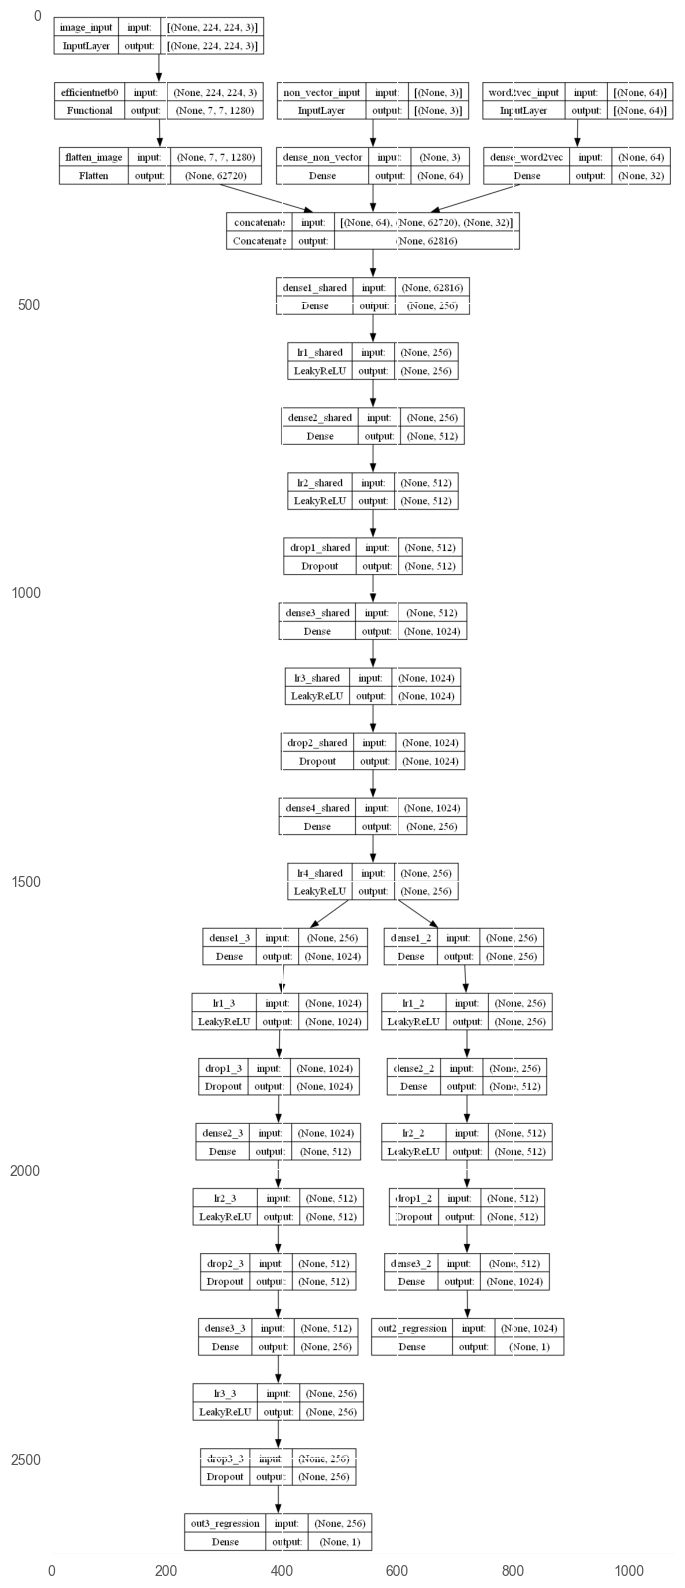

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Save the model plot as an image
plot_model(can_model_v2, to_file='can_modelV2_plot.png', show_shapes=True, show_layer_names=True)

# Display the saved image
img = mpimg.imread('can_modelV2_plot.png')
fig, ax = plt.subplots(figsize=(20, 20))
imgplot = plt.imshow(img)
plt.show()

In [ ]:
class Logger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("Logger Callback on Epoch End")
        out2_mae = logs.get('out2_regression_mean_absolute_error', None)
        out3_mae = logs.get('out3_regression_mean_absolute_error', None)
        val_out2_mae = logs.get('val_out2_mean_absolute_error', None)
        val_out3_mae = logs.get('val_out3_mean_absolute_error', None)

        print("=========********=========\n")
        print('=' * 30, epoch + 1, '=' * 30)

        # Check if the values are not None before formatting
        if out2_mae is not None and out3_mae is not None:
            print(f'out2_mae: {out2_mae:.2f}, out3_mae: {out3_mae:.2f}')

        if val_out2_mae is not None and val_out3_mae is not None:
            print(f'val_out2_mae: {val_out2_mae:.2f}, val_out3_mae: {val_out3_mae:.2f}')


In [ ]:
#tf.config.run_functions_eagerly(True)

input_data = {
    "non_vector_input": X_train_non_vector,
    "image_input": X_train_image_vector,
    "word2vec_input": np.array(X_train_word2vec_vector)
}

output_data = {
    "out2_regression": y_train_np[:, 0],
    "out3_regression": y_train_np[:, 1]
}

validation_data = {
    "non_vector_input": X_test_non_vector,
    "image_input": X_test_image_vector,
    "word2vec_input": np.array(X_test_word2vec_vector)
}

validation_output_data = {
    "out2_regression": y_test_np[:, 0],
    "out3_regression": y_test_np[:, 1]
}

history = can_model_v2.fit(
    input_data,
    output_data,
    batch_size=32,
    epochs=50,
    # callbacks=[Logger(), tf.keras.callbacks.TensorBoard(log_dir="./logs/")],
    validation_data=(validation_data, validation_output_data),
    verbose=True
)

Epoch 1/50
5/5 [==============================] - 6s 841ms/step - loss: 83576.4844 - out2_regression_loss: 1402.6144 - out3_regression_loss: 82173.8750 - out2_regression_mean_absolute_error: 17.5184 - out3_regression_mean_absolute_error: 158.1209 - val_loss: 543543.8125 - val_out2_regression_loss: 2478.5564 - val_out3_regression_loss: 541065.2500 - val_out2_regression_mean_absolute_error: 31.3106 - val_out3_regression_mean_absolute_error: 491.1830
Epoch 2/50
5/5 [==============================] - 3s 644ms/step - loss: 154429.0312 - out2_regression_loss: 1064.1503 - out3_regression_loss: 153364.8750 - out2_regression_mean_absolute_error: 15.9433 - out3_regression_mean_absolute_error: 211.2972 - val_loss: 358978.9375 - val_out2_regression_loss: 629.3055 - val_out3_regression_loss: 358349.6250 - val_out2_regression_mean_absolute_error: 15.6615 - val_out3_regression_mean_absolute_error: 401.2612
Epoch 3/50
5/5 [==============================] - 3s 630ms/step - loss: 173976.8750 - out2_regr

In [ ]:
#Save the Model
can_model_v2.save("aigot_can_model.h5")

c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



<div style="font-size: 90%;"><strong>2. USING A ONE STEP APPROACH FOR ONLY IMPRESSIONS</strong></div>

In [ ]:
ads_insight_df = pd.read_csv("../all_ads_data.csv")
campaigns_df = pd.read_csv("../all_ad_creatives_with_insights.csv")

In [ ]:
#
ads_insight_df['adcreatives_body'] = ads_insight_df['adcreatives'].swifter.apply(extract_adcreative_body)
ads_insight_df["image_url"] = ads_insight_df["adcreatives"].swifter.apply(extract_adcreative_image)

Pandas Apply: 100%|██████████| 636/636 [00:00<00:00, 14597.67it/s]


In [ ]:
ads_insight_df.head()

,adcreatives,adset,campaign,created_time,id,name,adcreatives_body,image_url
0,{'data': [{'effective_object_story_id': '14091...,"<AdSet> {\n ""id"": ""120202176749660035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-12-06T15:19:43+0100,120202176749710035,Nuova inserzione Interazioni,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...
1,"{'data': [{'body': ""Celebrare i momenti specia...","<AdSet> {\n ""id"": ""120201758028270035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T14:06:50+0100,120201758028320035,Nuova inserzione Interazioni,Celebrare i momenti speciali in luoghi altrett...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...
2,"{'data': [{'body': ""🎉✨ Benvenuti nel nostro es...","<AdSet> {\n ""id"": ""120201758189670035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T12:59:09+0100,120201758189720035,Nuova inserzione Interazioni,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...,https://scontent.fflr2-1.fna.fbcdn.net/v/t39.3...
3,{'data': [{'effective_object_story_id': '10040...,"<AdSet> {\n ""id"": ""120202597513850390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-14T11:33:58+0100,120202597513830390,Nuovo pacchetto: Interazioni Inserzione con im...,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...
4,"{'data': [{'body': ""🎅Ci stiamo avvolgendo nell...","<AdSet> {\n ""id"": ""120201422366960390"",\n ...","<Campaign> {\n ""account_id"": ""6596519296300...",2023-12-01T16:20:38+0100,120201442215360390,menu base - Copia,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...


In [ ]:
campaigns_df.head(2)

,ad_id,age,campaign_id,clicks,cpm,date_start,date_stop,gender,impressions,reach
0,120205380158210033,18-24,120205380158220033,1,4.693878,2024-01-09,2024-02-07,female,49,43
1,120205380158210033,18-24,120205380158220033,0,4.523810,2024-01-09,2024-02-07,male,42,36


In [ ]:
#Download the images now
import requests
from urllib.parse import urlparse
import os
# import time

def is_valid_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False


default_extension = '.jpg'
def download_images(image_urls, download_folder):
    image_paths = []
    for image_url in image_urls:
        if is_valid_url(image_url):
            response = requests.get(image_url)

            # Extract filename from URL
            parsed_url = urlparse(image_url)
            image_name = os.path.basename(parsed_url.path)

            # Remove invalid characters from filename
            image_name = ''.join(c if c.isalnum() or c in ['.', '_'] else '_' for c in image_name)

            # Split the filename into base name and extension
            base_name, extension = os.path.splitext(image_name)

            # If no extension or extension is invalid, use default_extension
            if not extension or extension.lower() not in ['.jpg', '.jpeg', '.png', '.gif']:
                extension = default_extension

            image_path = os.path.join(os.getcwd(), download_folder, f"{base_name}{extension}")

            with open(image_path, 'wb') as f:
                f.write(response.content)
                # time.sleep(2)

            image_paths.append(image_path)
        else:
            image_paths.append(None)

    return image_paths

In [ ]:
# Create a folder for downloaded images
download_folder = 'downloaded_images_per_cpm'
os.makedirs(download_folder, exist_ok=True)

image_urls = ads_insight_df['image_url'].dropna().apply(lambda x: x.strip())

# Download images
valid_image_urls = image_urls[image_urls.apply(is_valid_url)].reset_index(drop=True)

image_paths_series = pd.Series(download_images(valid_image_urls, download_folder), index=valid_image_urls.index)

ads_insight_df["image_path"] = image_paths_series

In [ ]:
ads_insight_df.head(2)

,adcreatives,adset,campaign,created_time,id,name,adcreatives_body,image_url,image_path
0,{'data': [{'effective_object_story_id': '14091...,"<AdSet> {\n ""id"": ""120202176749660035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-12-06T15:19:43+0100,120202176749710035,Nuova inserzione Interazioni,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...
1,"{'data': [{'body': ""Celebrare i momenti specia...","<AdSet> {\n ""id"": ""120201758028270035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T14:06:50+0100,120201758028320035,Nuova inserzione Interazioni,Celebrare i momenti speciali in luoghi altrett...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...


In [ ]:
valid_image_paths = ads_insight_df["image_path"].dropna()

# Apply the function to each valid image path in the dataframe
ads_insight_df.loc[valid_image_paths.index, "image_array"] = valid_image_paths.swifter.apply(lambda x: load_and_preprocess_image(x))

Pandas Apply:  72%|███████▏  | 458/635 [00:12<00:02, 81.32it/s] 

Error processing image at c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\conditional_attention_network\downloaded_images_per_cpm\16853587870224659985.jpg: cannot identify image file 'c:\\Users\\Aigot-Developer\\Desktop\\PROJECTS\\AIGOT\\Backup_Data_Formats\\conditional_attention_network\\downloaded_images_per_cpm\\16853587870224659985.jpg'


Pandas Apply: 100%|██████████| 635/635 [00:17<00:00, 36.09it/s]


In [ ]:
ads_insight_df.head(2)

,adcreatives,adset,campaign,created_time,id,name,adcreatives_body,image_url,image_path,image_array
0,{'data': [{'effective_object_story_id': '14091...,"<AdSet> {\n ""id"": ""120202176749660035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-12-06T15:19:43+0100,120202176749710035,Nuova inserzione Interazioni,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[212.0, 187.0, 165.0], [213.0, 187.0, 165.0]..."
1,"{'data': [{'body': ""Celebrare i momenti specia...","<AdSet> {\n ""id"": ""120201758028270035"",\n ...","<Campaign> {\n ""account_id"": ""6842150671417...",2023-11-30T14:06:50+0100,120201758028320035,Nuova inserzione Interazioni,Celebrare i momenti speciali in luoghi altrett...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[255.0, 250.0, 247.0], [255.0, 250.0, 247.0]..."


In [ ]:
#Merge the Dataframe using the Campaign ID as the common field
ads_insight_df["campaign_id"] = ads_insight_df["campaign"].swifter.apply(extract_campaign_id)

ads_insight_df['campaign_id'] = ads_insight_df['campaign_id'].astype('int64')

Pandas Apply: 100%|██████████| 636/636 [00:00<00:00, 211645.30it/s]


In [ ]:
#Merge the Dataframe using the Campaign ID as the common field
df_merged = pd.merge(ads_insight_df, campaigns_df, on="campaign_id", how="inner")
df_merged.head(2)

,adcreatives,adset,campaign,created_time,id,name,adcreatives_body,image_url,image_path,image_array,campaign_id,ad_id,age,clicks,cpm,date_start,date_stop,gender,impressions,reach
0,{'data': [{'effective_object_story_id': '56265...,"<AdSet> {\n ""id"": ""120205380158230033"",\n ...","<Campaign> {\n ""account_id"": ""2572739292893...",2024-02-06T15:41:35+0100,120205380158210033,Nuovo pacchetto: Interazioni Inserzione con im...,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[96.0, 0.0, 6.0], [96.0, 0.0, 6.0], [96.0, 0...",120205380158220033,120205380158210033,18-24,1,4.693878,2024-01-09,2024-02-07,female,49,43
1,{'data': [{'effective_object_story_id': '56265...,"<AdSet> {\n ""id"": ""120205380158230033"",\n ...","<Campaign> {\n ""account_id"": ""2572739292893...",2024-02-06T15:41:35+0100,120205380158210033,Nuovo pacchetto: Interazioni Inserzione con im...,None,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[96.0, 0.0, 6.0], [96.0, 0.0, 6.0], [96.0, 0...",120205380158220033,120205380158210033,18-24,0,4.523810,2024-01-09,2024-02-07,male,42,36


In [ ]:
# Check the None fopr the Adcreatives body
null_mask = df_merged.isnull().any(axis=1)
null_rows = df_merged["adcreatives_body"][null_mask]

print(f"Shape of Merged DF {df_merged.shape}")
print(f"Num of Null Rows {len(null_rows)}")

Shape of Merged DF (228, 20)
Num of Null Rows 140


In [ ]:
#Since there are null values, check and drop it
df_merged.dropna(inplace=True)

In [ ]:
# Check the None fopr the Adcreatives body
null_mask = df_merged.isnull().any(axis=1)
null_rows = df_merged["adcreatives_body"][null_mask]

print(f"Shape of Merged DF {df_merged.shape}")
print(f"Num of Null Rows {len(null_rows)}")

Shape of Merged DF (88, 20)
Num of Null Rows 0


In [ ]:
# df_merged = pd.read_csv("../df_merged_backup.csv")
df_merged.head(2)

#Uncomment if you want to save the dataframe
# df_merged.to_csv("df_merged_backup.csv")

,adcreatives,adset,campaign,created_time,id,name,adcreatives_body,image_url,image_path,image_array,campaign_id,ad_id,age,clicks,cpm,date_start,date_stop,gender,impressions,reach
18,{'data': [{'body': 'Vieni a scoprire la magia ...,"<AdSet> {\n ""id"": ""120204180956850080"",\n ...","<Campaign> {\n ""account_id"": ""3505879773063...",2024-01-10T10:20:32+0100,120204180956890080,Foto Pizza,Vieni a scoprire la magia della vera pizza Nap...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",120204180956780080,120204180956890080,18-24,18,1.511704,2024-01-09,2024-02-07,female,806,584
19,{'data': [{'body': 'Vieni a scoprire la magia ...,"<AdSet> {\n ""id"": ""120204180956850080"",\n ...","<Campaign> {\n ""account_id"": ""3505879773063...",2024-01-10T10:20:32+0100,120204180956890080,Foto Pizza,Vieni a scoprire la magia della vera pizza Nap...,https://scontent.fflr2-1.fna.fbcdn.net/v/t45.1...,c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGO...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",120204180956780080,120204180956890080,18-24,13,2.833327,2024-01-09,2024-02-07,male,779,472


In [ ]:
columns_to_select = ['adcreatives_body', 'image_array', 'cpm']

# Create the final dataframe (Dataframe 3) with the condition
final_df = df_merged[df_merged['adcreatives_body'].notna()][columns_to_select]
final_df.head(2)

,adcreatives_body,image_array,cpm
18,Vieni a scoprire la magia della vera pizza Nap...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",1.511704
19,Vieni a scoprire la magia della vera pizza Nap...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",2.833327


In [ ]:
# Remove the Stopwords by passing into the Hero Pipeline
final_df["clean_adcreative_body"] = hero.clean(final_df["adcreatives_body"])

#Remove Stop Words from the Column
final_df["clean_adcreative_body"] = final_df["clean_adcreative_body"].swifter.apply(lambda x: ' '.join([word for word in x.split() if word not in (aigot_custom_stopwords)]))
final_df.head(2)

Pandas Apply: 100%|██████████| 88/88 [00:00<00:00, 87964.43it/s]


,adcreatives_body,image_array,cpm,clean_adcreative_body
18,Vieni a scoprire la magia della vera pizza Nap...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",1.511704,vieni scoprire magia vera pizza napoletana pis...
19,Vieni a scoprire la magia della vera pizza Nap...,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",2.833327,vieni scoprire magia vera pizza napoletana pis...


In [ ]:
# Plot the stop words for this dataframe
tw = hero.visualization.top_words(final_df["clean_adcreative_body"]).head(10)
import plotly.express as px

fig = px.bar(tw)
fig.show()
tw.head()

clean_adcreative_body
febbraio      72
mealbox       54
menu          54
presidente    54
pisa          52
Name: count, dtype: int64

In [ ]:
final_df = final_df.drop('adcreatives_body', axis=1)
final_df.head(2)

,image_array,cpm,clean_adcreative_body
18,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",1.511704,vieni scoprire magia vera pizza napoletana pis...
19,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",2.833327,vieni scoprire magia vera pizza napoletana pis...


In [ ]:
# Make Tf-Idf of the Description
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

cards = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(final_df["clean_adcreative_body"])]

#Model instantiating
model = Doc2Vec(vector_size=64, window=2, workers=8, min_count=1, epochs =40)

#Build the vocabs
model.build_vocab(cards)

# Train the model
model.train(cards, total_examples=model.corpus_count, epochs=model.epochs)

# Generate vectors, skipping rows where 'clean_adcreative_body' is empty
card2vec = [model.infer_vector(row.split()) for row in final_df['clean_adcreative_body'] if pd.notna(row) and row.strip()]

#Create a list of lists
dtv= np.array(card2vec).tolist()

#set list to dataframe column
final_df['adcreative_word2vec'] = dtv

final_df.head(2)

,image_array,cpm,clean_adcreative_body,adcreative_word2vec
18,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",1.511704,vieni scoprire magia vera pizza napoletana pis...,"[-0.023828020319342613, 0.01629415713250637, 0..."
19,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",2.833327,vieni scoprire magia vera pizza napoletana pis...,"[-0.021696321666240692, 0.018789490684866905, ..."


In [ ]:
final_df = final_df.drop('clean_adcreative_body', axis=1).reset_index()
final_df.head(2)

,index,image_array,cpm,adcreative_word2vec
0,18,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",1.511704,"[-0.023828020319342613, 0.01629415713250637, 0..."
1,19,"[[[95.0, 90.0, 94.0], [96.0, 92.0, 93.0], [94....",2.833327,"[-0.021696321666240692, 0.018789490684866905, ..."


In [ ]:
#Save the CSV file now
final_df = final_df.drop('index', axis=1)
final_df.to_csv("../final_df_backup.csv", index=False)

In [ ]:
#Read the CSV file that was saved
final_df = pd.read_csv(r"C:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\final_df_backup.csv")
final_df.head(2)

,image_array,cpm,adcreative_word2vec
0,[[[ 95. 90. 94.]\n [ 96. 92. 93.]\n [ 94...,1.511704,"[-0.047150880098342896, -0.027570663020014763,..."
1,[[[ 95. 90. 94.]\n [ 96. 92. 93.]\n [ 94...,2.833327,"[-0.04560212045907974, -0.032711662352085114, ..."


In [ ]:
X = final_df.drop(columns="cpm", axis=1)
y = final_df["cpm"]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Now Split the X and Y cols using the Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Extract individual columns from DataFrames
X_train_image_vector = np.array([np.array(x) for x in X_train["image_array"]])
X_train_word2vec_vector = np.asarray(X_train["adcreative_word2vec"]).tolist()

X_test_image_vector = np.array([np.array(x) for x in X_test["image_array"]])
X_test_word2vec_vector = np.asarray(X_test["adcreative_word2vec"]).tolist()

#Apply the MinMaxScaler to the y-values
scaler = MinMaxScaler((0, 1))

# Fit and transform on training data
y_train_scaled = scaler.fit_transform(np.array(y_train, dtype=np.float32).reshape(-1, 1))

# Transform on test data
y_test_scaled = scaler.transform(np.array(y_test, dtype=np.float32).reshape(-1, 1))

In [ ]:
def preprocess_data_v2(X, y, test_size = 0.20, shuffle=True):
    #Now Split the X and Y cols using the Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=shuffle)

    # Extract individual columns from DataFrames
    X_train_image_vector = np.array([np.array(x) for x in X_train["image_array"]])
    X_train_word2vec_vector = np.asarray(X_train["adcreative_word2vec"]).tolist()

    X_test_image_vector = np.array([np.array(x) for x in X_test["image_array"]])
    X_test_word2vec_vector = np.asarray(X_test["adcreative_word2vec"]).tolist()

    # Convert labels to numpy arrays
    y_train_np = np.asarray(y_train, dtype=np.float32)
    y_test_np = np.asarray(y_test, dtype=np.float32)

    return X_train_image_vector, X_train_word2vec_vector, y_train_np, X_test_image_vector, X_test_word2vec_vector, y_test_np


In [ ]:
# from tensorflow.keras.applications import EfficientNetB0
from keras import regularizers


word2vec_input_shape = np.array(X_train_word2vec_vector[0]).shape

# Create Custom NN Model
def create_can_model_v2():
    # Define Image input
    image_input = Input(shape=(224,224,3), name="image_input")
    # image_features = vit_model(image_input)
    image_features = Flatten(name="flatten_image")(image_input)

    # Define the Sentence input
    word2vec_vector_input = Input(shape=word2vec_input_shape, name='word2vec_input')
    word2vec_vector_output = Dense(64, activation='relu', name="dense_word2vec")(word2vec_vector_input)

    # Concatenate the branches
    merged = concatenate([image_features, word2vec_vector_output])

    dense1_shared = Dense(64, name="dense1_shared", kernel_regularizer=regularizers.L2(l2=0.01))(merged)
    lr1_shared = LeakyReLU(alpha=0.01, name="lr1_shared")(dense1_shared)
    dense2_shared = Dense(32, name="dense2_shared",  kernel_regularizer=regularizers.L2(l2=0.02))(lr1_shared)
    lr2_shared = LeakyReLU(alpha=0.01, name="lr2_shared")(dense2_shared)
    drop3_3 = Dropout(0.05, name="drop3_3")(lr2_shared)
    out3 = Dense(1, activation="linear", name="out3_regression")(drop3_3)

    # Define inputs and outputs
    inputs = [image_input, word2vec_vector_input]
    outputs = [out3]

    # Compile the Model
    final_model = Model(inputs=inputs, outputs=outputs)

    # Create the final model
    final_model.compile(optimizer='adam', loss='mean_absolute_error', metrics='mean_absolute_error')

    return final_model

###### Evaluating the Neural Network to know the best Batch Size and Epoch

In [ ]:
new_model = create_can_model_v2()

HISTORY = new_model.fit(x=[X_train_image_vector, np.array(X_train_word2vec_vector)], y=y_train_scaled, batch_size=16, epochs=100, verbose=0)

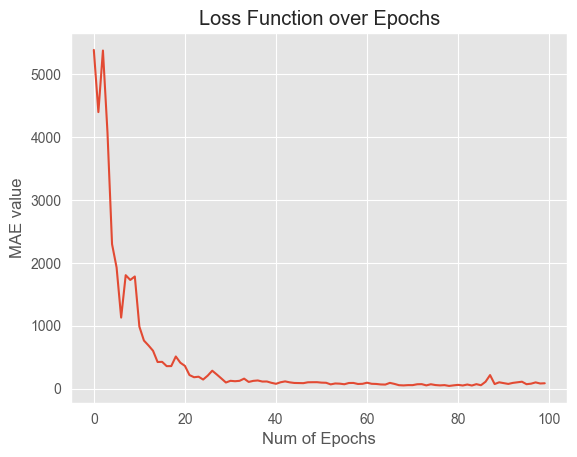

In [ ]:
# Plot the graph & check the efficient values
plt.plot(HISTORY.history["mean_absolute_error"])
plt.title("Loss Function over Epochs")
plt.ylabel("MAE value")
plt.xlabel("Num of Epochs")
plt.show()

In [ ]:
# Check the predictions to see if the values are close to the predictions
from prettytable import PrettyTable

# Y prediction for the X test variables
y_pred_scaled = new_model.predict(x=[X_test_image_vector, np.array(X_test_word2vec_vector)])
y_predInverse = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# Convert the pandas Series to a NumPy array before reshaping
y_test_array = np.array(y_test)
y_testInverse = scaler.inverse_transform(y_test_array.reshape(-1, 1))

combinedArray = np.column_stack((y_testInverse[0:10], y_predInverse[0:10]))

# Create a PrettyTable instance
table = PrettyTable()

# Define column names
table.field_names = ["Actual CPM", "Predicted CPM"]

# Add data to the table
for row in combinedArray:
    table.add_row(np.around(row, decimals=2))  # Round the entire row to 2 decimal places

# Print the table
print(table)

1/1 [==============================] - 0s 114ms/step
+------------+---------------+
| Actual CPM | Predicted CPM |
+------------+---------------+
|   11.67    |     80.71     |
|   10.23    |     58.22     |
|    5.56    |     102.0     |
|    7.17    |     102.0     |
|   10.14    |     58.22     |
|   11.57    |     123.96    |
|   11.62    |     58.22     |
|   12.84    |     102.0     |
|   11.23    |     58.22     |
|   10.49    |     123.96    |
+------------+---------------+


###### BEGIN THE GRID_SEARCH_WITH CROSS VALIDATION OF 5

In [ ]:
# Using Grid Search CV
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# Flatten the X_train_image_vector to make it 2D
X_train_image_vector_flattened = np.array(X_train_image_vector).reshape(70, -1)

# Reshape X_train_word2vec_vector to match the number of dimensions in X_train_image_vector
X_train_word2vec_vector_reshaped = np.array(X_train_word2vec_vector).reshape(-1, 64)

# Combine image and word2vec vectors
X_train_combined = np.concatenate([X_train_image_vector_flattened, X_train_word2vec_vector_reshaped], axis=1)


# Function to create the model
def create_can_model_v2(optimizer='adam'):
    # Define Image input
    image_input = Input(shape=(224 * 224 * 3,), name="image_input")
    image_features = Dense(224 * 224 * 3, activation='relu', name="dense_image")(image_input)

    # Define the Sentence input
    word2vec_vector_input = Input(shape=(64,), name='word2vec_input')
    word2vec_vector_output = Dense(64, activation='relu', name="dense_word2vec")(word2vec_vector_input)

    # Concatenate the branches
    merged = concatenate([image_features, word2vec_vector_output])

    dense1_shared = Dense(64, name="dense1_shared", kernel_regularizer=regularizers.L2(l2=0.01))(merged)
    lr1_shared = LeakyReLU(alpha=0.01, name="lr1_shared")(dense1_shared)
    dense2_shared = Dense(32, name="dense2_shared", kernel_regularizer=regularizers.L2(l2=0.02))(lr1_shared)
    lr2_shared = LeakyReLU(alpha=0.01, name="lr2_shared")(dense2_shared)
    drop3_3 = Dropout(rate=0.05, name="drop3_3")(lr2_shared)
    out3 = Dense(1, activation="linear", name="out3_regression")(drop3_3)

    # Define inputs and outputs
    inputs = [image_input, word2vec_vector_input]
    outputs = [out3]

    # Compile the Model
    final_model = Model(inputs=inputs, outputs=outputs)
    final_model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

    return final_model

In [ ]:
#Initialize the Keras Regressor with the new model
model = KerasRegressor(model=create_can_model_v2, verbose=0)

# Create a dictionary for inputs
param_grid = {
    'batch_size': [8, 16],
    'epochs': [5, 10, 15],
    'optimizer': ['adam', 'rmsprop'],
}


#Initialize the GridSearch with params such as Cross-Validation, Scoring ...
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)


grid_result = grid_search.fit(X=X_train_combined, y=y_train_scaled)

ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\scikeras\wrappers.py", line 760, in fit
    self._fit(
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\scikeras\wrappers.py", line 915, in _fit
    X, y = self._initialize(X, y)
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\scikeras\wrappers.py", line 852, in _initialize
    self.model_ = self._build_keras_model()
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\scikeras\wrappers.py", line 429, in _build_keras_model
    model = final_build_fn(**build_params)
  File "C:\Users\Aigot-Developer\AppData\Local\Temp\ipykernel_19604\1040115752.py", line 19, in create_can_model_v2
    image_features = Dense(224 * 224 * 3, activation='relu', name="dense_image")(image_input)
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\Aigot-Developer\Desktop\PROJECTS\AIGOT\Backup_Data_Formats\.venv\lib\site-packages\keras\src\backend.py", line 2100, in random_uniform
    return tf.random.stateless_uniform(
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[150528,150528] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:StatelessRandomUniformV2] name: 


In [ ]:
## Display the best parameters and results
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

In [ ]:
!nvidia-smi

Fri Feb 16 17:43:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.42                 Driver Version: 537.42       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX450         WDDM  | 00000000:2B:00.0 Off |                  N/A |
| N/A   63C    P8              N/A / ERR! |    294MiB /  2048MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<div style="font-size: 70%;">

##### BACKUP FOR GRID SEARCH FUNCTIONALITY
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Concatenate
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

###### Sample data for illustration
n_samples = 70
X_train_image_vector = np.random.rand(n_samples, 224, 224, 3)
X_train_word2vec_vector = np.random.rand(n_samples, 64)
y_train_scaled = np.random.rand(n_samples, 1)

###### Flatten X_train_image_vector to make it 2D
X_train_image_vector_flattened = np.array(X_train_image_vector).reshape(n_samples, -1)

###### Reshape X_train_word2vec_vector to match the number of dimensions in X_train_image_vector
X_train_word2vec_vector_reshaped = np.array(X_train_word2vec_vector).reshape(-1, 64)

###### Combine image and word2vec vectors
X_train_combined = np.concatenate([X_train_image_vector_flattened, X_train_word2vec_vector_reshaped], axis=1)

###### Function to create the model
def create_can_model(optimizer='adam'):
    combi_input = Input(shape=(224 * 224 * 3 + 64,), name="combi_input")

    # Process the combined input here
    x = Dense(32, activation='relu')(combi_input)
    output = Dense(1, activation='linear', name='output')(x)

    model = Model(inputs=combi_input, outputs=output)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_absolute_error'])

    return model

###### Using KerasRegressor wrapper for compatibility with GridSearchCV
model = KerasRegressor(build_fn=create_can_model, verbose=0)

###### Define parameters for GridSearch
param_grid = {
    'batch_size': [10, 20],
    'epochs': [10, 5],
    'optimizer': ['adam', 'SGD']
}

###### Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

###### Fit the model
grid_result = grid_search.fit(X_train_combined, y_train_scaled)

###### Display the best parameters and results
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

</div>

<div style="font-size: 70%;">
import chainer
import logzero

from chainer import training
from chainer.training import extensions
from gensim.models import KeyedVectors

from models import ARCHS, MODEL_WRAPPERS
from util import const
from util.args import parse_train_args as parse_args
from util.cross_validation import kfold_iter

from util.evaluate import EVALUATE_PHASES

from util.extensions import (
    setup_optim_trigger,
    setup_plot_report_loss_entries,
    setup_print_report_entries,
    setup_record_trigger,
)
from util.load import load_data
from util.notify import notify_exception, notify_result
from util.preprocessed_dataset import (
    PreprocessedDataset,
    convert_seq,
    prepare_vectorizer,
)
from util.resource import Resource
from util.seed import reset_seed

from collections import OrderedDict


plt.style.use("ggplot")
chainer.cuda.set_max_workspace_size(1024 * 1024 * 1024)
chainer.global_config.autotune = True


def main(args):
    reset_seed(args.seed)

    res = Resource(args, train=True)

    pretrained_word2vec = KeyedVectors.load_word2vec_format(
        str(const.PRETRAINED_WORD2VEC_FPATH), binary=True
    )

    vectorizer = prepare_vectorizer(
        pretrained_word2vec,
        args.training_type,
        norm_imp=const.NORMALIZED_IMPRESSION,
        is_impnorm=args.imp_norm,
        is_logarithm=True,
    )

    df = load_data(const.TRAIN_DATA_FPATH)

    kf = kfold_iter(
        X=df,
        y=df[args.objective],
        n_splits=args.fold,
        random_state=args.seed,
        is_campaign_group=args.group,
        training_type=args.training_type,
        campaign_ids=df["campaign_id"].values,
    )

    scores = OrderedDict(
        [(metric, []) for metric in const.EVALUATION_METRIC[args.training_type]]
    )

    res.loginfo("Start Training")
    for i, (train_idx, val_idx) in enumerate(kf):
        res.loginfo("Fold: {}".format(i + 1))

        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        df_train = vectorizer.fit_transform(df_train)
        df_val = vectorizer.fit_transform(df_val)

        n_age = len(vectorizer.named_steps.age.le.classes_)
        n_gender = len(vectorizer.named_steps.gender.lb.classes_)

        res.logdebug("# of Ages: {}".format(n_age))
        res.logdebug("# of Gender: {}".format(n_gender))

        train_pairs = PreprocessedDataset(
            df_train, args.training_type, output_cols=args.objective
        )
        val_pairs = PreprocessedDataset(
            df_val, args.training_type, output_cols=args.objective
        )

        train_iter = chainer.iterators.SerialIterator(train_pairs, args.batchsize)
        val_iter = chainer.iterators.SerialIterator(
            val_pairs, args.batchsize, repeat=False, shuffle=False
        )

        is_update_w2v = args.word_embedding == const.WORD2VEC_UPDATE
        encoder = ARCHS[args.arch](
            n_layers=args.layer,
            n_age=n_age,
            n_vocab=len(prepare_vectorizer.index2word),
            pretrained_w2v=pretrained_word2vec,
            is_update_w2v=is_update_w2v,
            dropout=args.dropout,
        )

        model = MODEL_WRAPPERS[args.training_type](
            encoder=encoder, dropout=args.dropout
        )

        if args.gpu >= 0:
            chainer.cuda.get_device_from(args.gpu).use()
            model.to_gpu()

        # Set up an optimizer
        optimizer = chainer.optimizers.Adam()
        optimizer.setup(model)
        optimizer.add_hook(chainer.optimizer.WeightDecay(args.weight_decay))

        # Setup a trainer
        updater = training.updaters.StandardUpdater(
            train_iter, optimizer, converter=convert_seq, device=args.gpu
        )
        trainer = training.Trainer(
            updater, (args.epoch, "epoch"), out=str(res.output_dir)
        )

        # Evaluate the model with the test dataset for each epoch
        trainer.extend(
            extensions.Evaluator(
                val_iter, model, device=args.gpu, converter=convert_seq
            )
        )

        # Take the best snapshot
        record_trigger = setup_record_trigger(args.training_type)
        optim_trigger = setup_optim_trigger(args.training_type)

        model_fname = "{}_{}_{}-fold_{}_best_model.npz".format(
            res.sdtime, args.training_type, i + 1, args.arch
        )
        trainer.extend(
            extensions.snapshot_object(model, model_fname), trigger=record_trigger
        )

        trainer.extend(extensions.ExponentialShift("alpha", 0.9), trigger=optim_trigger)

        # Generate a log of evaluation statistics for each epoch
        trainer_log_name = "{}_{}_{}-fold_{}_reporter.json".format(
            res.sdtime, args.training_type, i + 1, args.arch
        )

        trainer.extend(extensions.LogReport(log_name=trainer_log_name))
        trainer.extend(extensions.observe_lr())

        fig_loss_fpath = res.fig_loss_dir / "{}_{}_{}-fold_loss.png".format(
            res.sdtime, args.training_type, i + 1
        )
        fig_loss_path = fig_loss_fpath.relative_to(res.output_dir)
        plot_loss_entries = setup_plot_report_loss_entries(args.training_type)

        trainer.extend(
            extensions.PlotReport(
                plot_loss_entries, "epoch", filename=str(fig_loss_path), grid=False
            )
        )

        entries = setup_print_report_entries(args.training_type)
        trainer.extend(extensions.PrintReport(entries))

        trainer.extend(extensions.ProgressBar(update_interval=10))

        # Run the training
        trainer.run()

        if args.test:
            res.logger.debug("Start the test phase...")
            snapshot_best_model = res.output_dir / model_fname
            chainer.serializers.load_npz(str(snapshot_best_model), model)
            res.logdebug("Load: {}".format(str(snapshot_best_model)))

            # Calcculate scores
            calculated_scores = EVALUATE_PHASES[args.training_type](
                res=res,
                model=model,
                pairs=val_pairs,
                fold=i + 1,
                converter=convert_seq,
                vectorizer=vectorizer,
            ).test()

            for metric in scores.keys():
                scores[metric].append(calculated_scores[metric])
        
        if not args.cv:
            break

    
    res.dump_command_info()
    logger = logzero.setup_logger(
        name='test',
        logfile=str(res.log_dir / f'{res.sdtime}_test.log'),
    )
    for metric in scores.keys():
        logger.info(f"Average {metric}: {np.mean(scores[metric]):.6f}, var: {np.var(scores[metric]):.6f}")
    
    res.dump_duration()

    notify_result(res)
</div>

### Getting Post

In [6]:
df=pd.read_csv('/content/data.csv')
df['adcreatives_body']

0                                                    NaN
1      Celebrare i momenti speciali in luoghi altrett...
2      🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...
3                                                    NaN
4      🎅Ci stiamo avvolgendo nell'atmosfera natalizia...
                             ...                        
638    😍Leggi quello che i nostri clienti dicono di n...
639    😍Leggi quello che i nostri clienti dicono di n...
640    😍Leggi quello che i nostri clienti dicono di n...
641    😍Leggi quello che i nostri clienti dicono di n...
642    😍Leggi quello che i nostri clienti dicono di n...
Name: adcreatives_body, Length: 643, dtype: object

In [8]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/content/data.csv')

# Extract the 'adcreatives_body' column
adcreatives_body_column = df['adcreatives_body']

# Create a new DataFrame with only the 'adcreatives_body' column
adcreatives_body_df = pd.DataFrame(adcreatives_body_column)

# Save the extracted column to a new CSV file
adcreatives_body_df.to_csv('/content/adcreatives_body_column.csv', index=False)

print("adcreatives_body column saved to 'adcreatives_body_column.csv'")
# Read the CSV file
df = pd.read_csv('/content/adcreatives_body_column.csv')


adcreatives_body column saved to 'adcreatives_body_column.csv'


In [11]:
# Read the CSV file
df = pd.read_csv('/content/adcreatives_body_column.csv')
df.head()

,adcreatives_body
0,NaN
1,Celebrare i momenti speciali in luoghi altrett...
2,🎉✨ Benvenuti nel nostro esclusivo Cenone di Ca...
3,NaN
4,🎅Ci stiamo avvolgendo nell'atmosfera natalizia...
